### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.backend as K

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    #zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
                                                                )

train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [5]:
                                                              )
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                 subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [6]:

test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 1)

Found 1279 images belonging to 4 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

2023-01-08 10:34:55.696385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 10:34:55.777474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 10:34:55.778276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 10:34:55.779462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 1s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62720)             250880    
_________________________________________________________________
dense (Dense)                (None, 32)                2007072   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [14]:


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
                                                     
            

In [16]:
from tensorflow.keras.utils import to_categorical, plot_model
#plot_model(model, to_file='NN-mnist.png', show_shapes=True)

In [17]:
#model.load_weights("/kaggle/input/zahaimar-last/best_weights (1).hdf5")

In [18]:
from sklearn.utils import class_weight
import numpy as np
'''
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_dataset.classes), 
                train_dataset.classes)

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_dataset),
                                        y = train_dataset                                                    
                                    )
'''

'\nclass_weights = class_weight.compute_class_weight(\n               \'balanced\',\n                np.unique(train_dataset.classes), \n                train_dataset.classes)\n\nclass_weights = class_weight.compute_class_weight(\n                                        class_weight = "balanced",\n                                        classes = np.unique(train_dataset),\n                                        y = train_dataset                                                    \n                                    )\n'

In [19]:
from collections import Counter

In [20]:
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     


In [21]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [22]:

history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        verbose = 1,
                        class_weight=class_weights,
                        callbacks=[checkpoint_cb, lr_scheduler]
                 )

2023-01-08 10:35:02.417343: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-08 10:35:07.593072: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


129/129 [==============================] - 88s 605ms/step - loss: 3.0727 - accuracy: 0.2230 - precision: 0.2564 - recall: 0.0342 - auc: 0.5050 - f1_score: 0.0567 - val_loss: 1.3781 - val_accuracy: 0.1975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4933 - val_f1_score: 0.0000e+00


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
129/129 [==============================] - 49s 378ms/step - loss: 2.8516 - accuracy: 0.2064 - precision: 0.2043 - recall: 0.0093 - auc: 0.4940 - f1_score: 0.0170 - val_loss: 1.3381 - val_accuracy: 0.4506 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7107 - val_f1_score: 0.0000e+00
Epoch 3/100
129/129 [==============================] - 49s 376ms/step - loss: 2.8579 - accuracy: 0.2408 - precision: 0.2041 - recall: 0.0024 - auc: 0.5235 - f1_score: 0.0047 - val_loss: 1.3959 - val_accuracy: 0.1554 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4240 - val_f1_score: 0.0000e+00
Epoch 4/100
129/129 [==============================] - 49s 380ms/step - loss: 2.7464 - accuracy: 0.2379 - precision: 0.5429 - recall: 0.0093 - auc: 0.5419 - f1_score: 0.0177 - val_loss: 1.4082 - val_accuracy: 0.1378 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3515 - val_f1_score: 0.0000e+00
Epoch 5/100
129/129 [==============================] - 49s

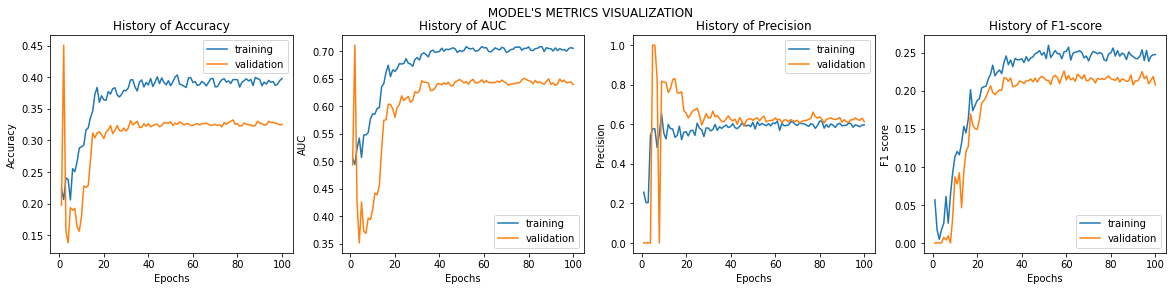

In [42]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    
    ax2.plot(range(1, len(auc) + 1), auc)
    ax2.plot(range(1, len(val_auc) + 1), val_auc)
    ax2.set_title('History of AUC')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('AUC')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(precision) + 1), precision)
    ax3.plot(range(1, len(val_precision) + 1), val_precision)
    ax3.set_title('History of Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(f1) + 1), f1)
    ax4.plot(range(1, len(val_f1) + 1), val_f1)
    ax4.set_title('History of F1-score')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('F1 score')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [43]:
scores = model.evaluate(test_dataset)

1279/1279 [==============================] - 15s 11ms/step - loss: 1.0762 - accuracy: 0.4433 - precision: 0.6829 - recall: 0.2408 - auc: 0.7617 - f1_score: 0.2408


In [28]:
#model.save('/kaggle/working/zahaimar_v2.h5')

In [44]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.4433150887489319
Precision =  0.6829268336296082
Recall =  0.24081313610076904
AUC =  0.7617465257644653
F1_score =  0.24081310629844666


In [26]:
def predict_prob(number):
  return [number[0],1-number[0]]

# Test on the model

68.13 % chances are there that the image is [2]


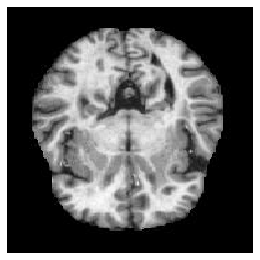

In [33]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented/nonDem0.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

In [30]:
import numpy as np
import pandas as pd 
import seaborn as sn 
import tensorflow as tf

35.53 % chances are there that the image is [0]


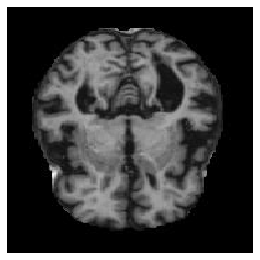

In [45]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

32.71 % chances are there that the image is class [1]


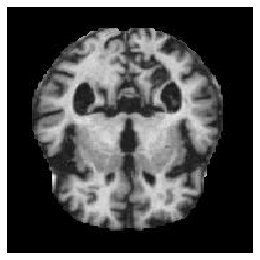

In [46]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented/moderateDem0.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

66.76 % chances are there that the image is class [2]


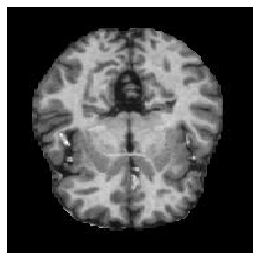

In [47]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented/nonDem1.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

In [48]:
true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

Mobile_preds = model.predict(test_dataset)
Mobile_preds_classes = np.argmax(Mobile_preds, axis=1)

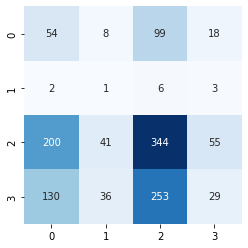

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, Mobile_preds_classes)    

plt.show()

#  Test on diffrent data

In [50]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [52]:
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/kaggle/input/alzheimer-mri-dataset/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical')

Found 6400 images belonging to 4 classes.


In [53]:
# Evaluating Loss and AUC

model.evaluate(test_dataset2)

200/200 [==============================] - 43s 214ms/step - loss: 1.0346 - accuracy: 0.4905 - precision: 0.5715 - recall: 0.3902 - auc: 0.7995 - f1_score: 0.4622


[1.0346429347991943,
 0.49046874046325684,
 0.5715266466140747,
 0.39015623927116394,
 0.7994797825813293,
 0.46218931674957275]

80.14 % chances are there that the image is class [2]


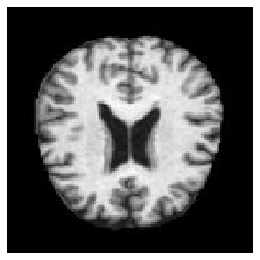

In [56]:
# Test Case 3: Moderate Demented

dic = test_dataset2.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/non.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

# Confusion Matrix

In [61]:
true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_dataset)
pred_classes = np.argmax(preds, axis=1)

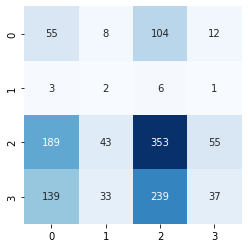

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, pred_classes)    

plt.show()